# Multi-Agent Routing with LangGraph

This notebook demonstrates how to build a multi-agent system that routes queries to specialized language models (LLMs) based on the query's content. We'll use LangGraph to create a stateful graph that manages the routing logic.

The original Python script, `ma_routing-v2.py`, defines a system with four mock LLMs:

- A code-specialized LLM
- A math-specialized LLM
- A creative-specialized LLM
- A general-purpose LLM

A router analyzes the user's query and directs it to the most appropriate LLM. This approach allows for more accurate and context-aware responses by leveraging specialized expertise.

## 1. Imports and State Definition

First, we import the necessary libraries. `TypedDict` is used to define the structure of our agent's state, and `StateGraph` and `END` are core components from LangGraph for building the graph.

The `AgentState` class defines the data that will be passed between nodes in our graph. It includes:

- `query`: The user's input string.
- `route`: The determined destination for the query (e.g., 'code', 'math').
- `response`: The final response from the selected LLM.
- `reasoning`: An explanation of why a particular route was chosen.

In [9]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, END
import re

# Define the state structure
class AgentState(TypedDict):
    query: str
    route: str
    response: str
    reasoning: str

## 2. Mock LLM Definitions

To simulate a multi-agent environment without requiring actual API calls, we define several mock LLM functions. Each function represents a specialized agent and returns a formatted string indicating which LLM was called.

In a real-world application, these would be replaced with actual calls to different LLM APIs or models.

In [10]:
# Mock LLM responses (replace with actual LLM calls)
def code_llm(query: str) -> str:
    """Specialized LLM for coding questions"""
    return f"[CODE LLM] Here's a programming solution for: {query}"

def math_llm(query: str) -> str:
    """Specialized LLM for math questions"""
    return f'[MATH LLM] Mathematical analysis of: {query}'

def general_llm(query: str) -> str:
    """General purpose LLM"""
    return f'[GENERAL LLM] General response to: {query}'

def creative_llm(query: str) -> str:
    """Specialized LLM for creative tasks"""
    return f'[CREATIVE LLM] Creative response to: {query}'

## 3. The Router Function

The `route_query` function is the core of our routing logic. It inspects the user's query for specific keywords to determine the most appropriate LLM. 

It uses predefined lists of keywords for different domains (code, math, creative). If a keyword is found, it sets the `route` and `reasoning` fields in the agent's state. If no specific keywords are matched, it defaults to the 'general' route.

In [11]:
def route_query(state: AgentState) -> AgentState:
    """Analyze query and determine which LLM to use"""
    query = state['query'].lower()

    # Code-related keywords
    code_keywords = [
        'python', 'javascript', 'code', 'function', 'programming', 
        'algorithm', 'debug', 'api', 'class', 'variable',
    ]

    # Math-related keywords
    math_keywords = [
        'calculate', 'equation', 'math', 'formula', 'solve', 
        'probability', 'statistics', 'derivative', 'integral',
    ]

    # Creative keywords
    creative_keywords = ['story', 'poem', 'creative', 'write', 'imagine', 'fictional', 'character', 'plot', 'narrative']

    # Determine route based on keyword matching
    if any(keyword in query for keyword in code_keywords):
        route = 'code'
        reasoning = 'Detected programming/coding related query'
    elif any(keyword in query for keyword in math_keywords):
        route = 'math'
        reasoning = 'Detected mathematical/calculation query'
    elif any(keyword in query for keyword in creative_keywords):
        route = 'creative'
        reasoning = 'Detected creative writing query'
    else:
        route = 'general'
        reasoning = 'No specific specialization detected, using general LLM'

    state['route'] = route
    state['reasoning'] = reasoning
    return state

## 4. Agent Nodes

Each of these functions represents a node in our graph. When the graph transitions to one of these nodes, the corresponding function is executed. Each function calls its specialized mock LLM with the query, and updates the `response` field in the state.

In [12]:
def handle_code_query(state: AgentState) -> AgentState:
    """Process query with code-specialized LLM"""
    response = code_llm(state['query'])
    state['response'] = response
    return state

def handle_math_query(state: AgentState) -> AgentState:
    """Process query with math-specialized LLM"""
    response = math_llm(state['query'])
    state['response'] = response
    return state

def handle_creative_query(state: AgentState) -> AgentState:
    """Process query with creative-specialized LLM"""
    response = creative_llm(state['query'])
    state['response'] = response
    return state

def handle_general_query(state: AgentState) -> AgentState:
    """Process query with general LLM"""
    response = general_llm(state['query'])
    state['response'] = response
    return state

## 5. Graph Construction

Now we build the graph using `StateGraph`.

1.  **Nodes**: We add the `router` and each of the specialized handler functions as nodes in the graph.
2.  **Entry Point**: We set the `router` node as the entry point. All queries will start here.
3.  **Conditional Edges**: After the `router` node, we use `add_conditional_edges`. The `determine_next_node` function reads the `route` from the state and tells the graph which specialized node to go to next.
4.  **End Points**: After each specialized node has done its work, it transitions to the `END` state, finishing the execution for that query.
5.  **Compilation**: Finally, we compile the workflow into a runnable application.

In [13]:
def determine_next_node(state: AgentState) -> Literal['code', 'math', 'creative', 'general']:
    """Return the next node based on routing decision"""
    return state['route']

def create_routing_agent():
    """Create and return the LangGraph routing agent"""

    # Initialize the graph
    workflow = StateGraph(AgentState)

    # Add nodes
    workflow.add_node('router', route_query)
    workflow.add_node('code', handle_code_query)
    workflow.add_node('math', handle_math_query)
    workflow.add_node('creative', handle_creative_query)
    workflow.add_node('general', handle_general_query)

    # Set entry point
    workflow.set_entry_point('router')

    # Add conditional edges from router to specialized nodes
    workflow.add_conditional_edges(
        'router', determine_next_node, {'code': 'code', 'math': 'math', 'creative': 'creative', 'general': 'general'}
    )

    # Add edges from specialized nodes to END
    workflow.add_edge('code', END)
    workflow.add_edge('math', END)
    workflow.add_edge('creative', END)
    workflow.add_edge('general', END)

    # Compile the graph
    app = workflow.compile()
    return app

## 6. Execution and Demonstration

The `run_example` function demonstrates the agent in action. It creates an instance of the routing agent and tests it with a list of diverse queries. 

For each query, it invokes the agent, prints the query, the route chosen by the agent, the reasoning behind the choice, and the response from the selected mock LLM. This shows how the routing logic directs different types of questions to the appropriate specialized agent.

In [ ]:
agent = create_routing_agent()
print('Subgraph structure:')
# Optional: Display a visualization of the graph's structure.
try:
    from IPython.display import Image, display

    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
    pass

LangGraph LLM-Powered Routing Agent Demo

1. Query: How do I implement a binary search algorithm in Python?
   Route: code
   Reasoning: Detected programming/coding related query
   Response: [CODE LLM] Here's a programming solution for: How do I implement a binary search algorithm in Python...
--------------------------------------------------

2. Query: What's the integral of 2x³ + 5x² - 3x + 7?
   Route: math
   Reasoning: Detected mathematical/calculation query
   Response: [MATH LLM] Mathematical analysis of: What's the integral of 2x³ + 5x² - 3x + 7?...
--------------------------------------------------

3. Query: Write a mysterious short story about a lighthouse keeper
   Route: creative
   Reasoning: Detected creative writing query
   Response: [CREATIVE LLM] Creative response to: Write a mysterious short story about a lighthouse keeper...
--------------------------------------------------

4. Query: What causes the northern lights phenomenon?
   Route: general
   Reasoning: No

In [ ]:

test_queries = [
    'How do I implement a binary search algorithm in Python?',
    "What's the integral of 2x³ + 5x² - 3x + 7?",
    'Write a mysterious short story about a lighthouse keeper',
    'What causes the northern lights phenomenon?',
    'Help me optimize this SQL query performance',
    'Solve for x: 3x² - 12x + 9 = 0',
]

print('LangGraph LLM-Powered Routing Agent Demo')
print('=' * 50)

for i, query in enumerate(test_queries, 1):
    print(f'\n{i}. Query: {query}')

    try:
        # Run the agent
        result = agent.invoke({'query': query})

        print(f'   Route: {result["route"]}')
        print(f'   Reasoning: {result["reasoning"]}')
        print(f'   Response: {result["response"][:100]}...')  # Truncate for demo

    except Exception as e:
        print(f'   Error: {str(e)}')

    print('-' * 50)

Subgraph structure:


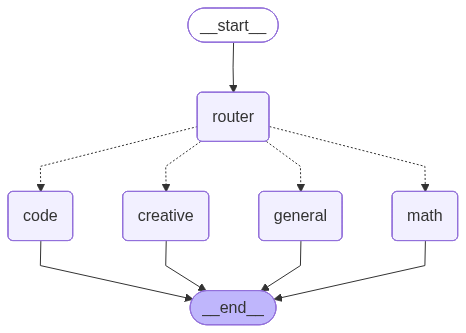

In [16]:
test_queries = [
    'How do I implement a binary search algorithm in Python?',
    "What's the integral of 2x³ + 5x² - 3x + 7?",
    'Write a mysterious short story about a lighthouse keeper',
    'What causes the northern lights phenomenon?',
    'Help me optimize this SQL query performance',
    'Solve for x: 3x² - 12x + 9 = 0',
]

print('LangGraph LLM-Powered Routing Agent Demo')
print('=' * 50)

for i, query in enumerate(test_queries, 1):
    print(f'\n{i}. Query: {query}')

    try:
        # Run the agent
        result = agent.invoke({'query': query})

        print(f'   Route: {result["route"]}')
        print(f'   Reasoning: {result["reasoning"]}')
        print(f'   Response: {result["response"][:100]}...')  # Truncate for demo

    except Exception as e:
        print(f'   Error: {str(e)}')

    print('-' * 50)

LangGraph LLM-Powered Routing Agent Demo

1. Query: How do I implement a binary search algorithm in Python?
   Route: code
   Reasoning: Detected programming/coding related query
   Response: [CODE LLM] Here's a programming solution for: How do I implement a binary search algorithm in Python...
--------------------------------------------------

2. Query: What's the integral of 2x³ + 5x² - 3x + 7?
   Route: math
   Reasoning: Detected mathematical/calculation query
   Response: [MATH LLM] Mathematical analysis of: What's the integral of 2x³ + 5x² - 3x + 7?...
--------------------------------------------------

3. Query: Write a mysterious short story about a lighthouse keeper
   Route: creative
   Reasoning: Detected creative writing query
   Response: [CREATIVE LLM] Creative response to: Write a mysterious short story about a lighthouse keeper...
--------------------------------------------------

4. Query: What causes the northern lights phenomenon?
   Route: general
   Reasoning: No